In [9]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = "./datasets/pet"
categories = ["colored_label_o","colored_label_x", "colorless_label_o", "colorless_label_x"]
nb_classes = len(categories)

image_w = 64
image_h = 64

pixels = image_h*image_w*3

X = []
y = []

#원핫인코딩
for idx, cat in enumerate(categories):
    label = [0 for i in range(nb_classes)]
    label[idx] = 1
    
    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir + "/*.jpg")
    print(cat,"파일 길이:", len(files))
    
    #이미지 데이터 전처리
    for i,f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img, dtype=object)
        
        X.append(data)
        y.append(label)
        
        if i % 700 == 0:
            print(cat,":",f)
            
X = np.array(X)
y = np.array(y)

#학습시킬 데이터와 테스트할 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("./numpy_data/multi_image_data.npy", xy)

print("ok", len(y))

colored_label_o 파일 길이: 37
colored_label_o : ./datasets/pet/colored_label_o\0399.jpg
colored_label_x 파일 길이: 18
colored_label_x : ./datasets/pet/colored_label_x\133.jpg
colorless_label_o 파일 길이: 197
colorless_label_o : ./datasets/pet/colorless_label_o\0004.jpg


C:\Users\LG\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


colorless_label_x 파일 길이: 165
colorless_label_x : ./datasets/pet/colorless_label_x\10.jpg
ok 417


C:\Users\LG\anaconda3\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [10]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend as K

#GPU 설정
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config = config)

#파일 로드 및 데이터 형태 확인
X_train, X_test, y_train, y_test = np.load('./numpy_data/multi_image_data.npy',
                                           allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])

(312, 64, 64, 3)
312


In [11]:
#픽셀 값 정규화
categories = ["colored_label_o","colored_label_x", "colorless_label_o", "colorless_label_x"]
nb_classes = len(categories)

X_train = X_train.astype(float)/255
X_test = X_test.astype(float)/255

In [12]:
#모델 구조 만들기
with K.tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32,(3,3),padding="same", input_shape=X_train.shape[1:], 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0,25))
    
    model.add(Conv2D(64,(3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0,5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
        
    model_path = model_dir+'/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                 verbose=1,save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 16384)            

In [14]:
#모델 학습
history = model.fit(X_train, y_train, batch_size = 32, epochs=50, 
                    validation_data=(X_test, y_test), callbacks=[checkpoint,
                                                                 early_stopping])

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 1.4269 - accuracy: 0.4327
Epoch 1: val_loss improved from inf to 1.30145, saving model to ./model\multi_img_classification.model


INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets


INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets


10/10 [==============================] - 8s 623ms/step - loss: 1.4269 - accuracy: 0.4327 - val_loss: 1.3014 - val_accuracy: 0.4190
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 1.1586 - accuracy: 0.4551
Epoch 2: val_loss improved from 1.30145 to 1.20943, saving model to ./model\multi_img_classification.model


INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets


INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets


10/10 [==============================] - 4s 459ms/step - loss: 1.1586 - accuracy: 0.4551 - val_loss: 1.2094 - val_accuracy: 0.5333
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.0630 - accuracy: 0.5897
Epoch 3: val_loss improved from 1.20943 to 1.04847, saving model to ./model\multi_img_classification.model


INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets


INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets


10/10 [==============================] - 5s 526ms/step - loss: 1.0630 - accuracy: 0.5897 - val_loss: 1.0485 - val_accuracy: 0.5905
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 0.9024 - accuracy: 0.6378
Epoch 4: val_loss improved from 1.04847 to 0.93240, saving model to ./model\multi_img_classification.model


INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets


INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets


10/10 [==============================] - 5s 500ms/step - loss: 0.9024 - accuracy: 0.6378 - val_loss: 0.9324 - val_accuracy: 0.5429
Epoch 5/50
10/10 [==============================] - ETA: 0s - loss: 0.7278 - accuracy: 0.7115
Epoch 5: val_loss improved from 0.93240 to 0.80425, saving model to ./model\multi_img_classification.model


INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets


INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets


10/10 [==============================] - 4s 475ms/step - loss: 0.7278 - accuracy: 0.7115 - val_loss: 0.8043 - val_accuracy: 0.6286
Epoch 6/50
10/10 [==============================] - ETA: 0s - loss: 0.5743 - accuracy: 0.7756
Epoch 6: val_loss did not improve from 0.80425
10/10 [==============================] - 2s 207ms/step - loss: 0.5743 - accuracy: 0.7756 - val_loss: 0.9128 - val_accuracy: 0.7048
Epoch 7/50
10/10 [==============================] - ETA: 0s - loss: 0.4851 - accuracy: 0.8045
Epoch 7: val_loss improved from 0.80425 to 0.76643, saving model to ./model\multi_img_classification.model


INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets


INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets


10/10 [==============================] - 5s 495ms/step - loss: 0.4851 - accuracy: 0.8045 - val_loss: 0.7664 - val_accuracy: 0.6952
Epoch 8/50
10/10 [==============================] - ETA: 0s - loss: 0.4392 - accuracy: 0.8494
Epoch 8: val_loss did not improve from 0.76643
10/10 [==============================] - 3s 261ms/step - loss: 0.4392 - accuracy: 0.8494 - val_loss: 0.9061 - val_accuracy: 0.7333
Epoch 9/50
10/10 [==============================] - ETA: 0s - loss: 0.3860 - accuracy: 0.8397
Epoch 9: val_loss improved from 0.76643 to 0.72862, saving model to ./model\multi_img_classification.model


INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets


INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets


10/10 [==============================] - 5s 511ms/step - loss: 0.3860 - accuracy: 0.8397 - val_loss: 0.7286 - val_accuracy: 0.7524
Epoch 10/50
10/10 [==============================] - ETA: 0s - loss: 0.2800 - accuracy: 0.9199
Epoch 10: val_loss did not improve from 0.72862
10/10 [==============================] - 2s 214ms/step - loss: 0.2800 - accuracy: 0.9199 - val_loss: 0.8046 - val_accuracy: 0.7238
Epoch 11/50
10/10 [==============================] - ETA: 0s - loss: 0.2423 - accuracy: 0.9199
Epoch 11: val_loss did not improve from 0.72862
10/10 [==============================] - 2s 214ms/step - loss: 0.2423 - accuracy: 0.9199 - val_loss: 0.8085 - val_accuracy: 0.7333
Epoch 12/50
10/10 [==============================] - ETA: 0s - loss: 0.1777 - accuracy: 0.9487
Epoch 12: val_loss did not improve from 0.72862
10/10 [==============================] - 2s 212ms/step - loss: 0.1777 - accuracy: 0.9487 - val_loss: 0.8586 - val_accuracy: 0.8190
Epoch 13/50
10/10 [============================

In [22]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

3/3 [==============================] - 0s 55ms/step - loss: 0.4540 - accuracy: 0.8085
정확도 : 0.8085


In [21]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

4/4 [==============================] - 0s 38ms/step


AxisError: axis 1 is out of bounds for array of dimension 1

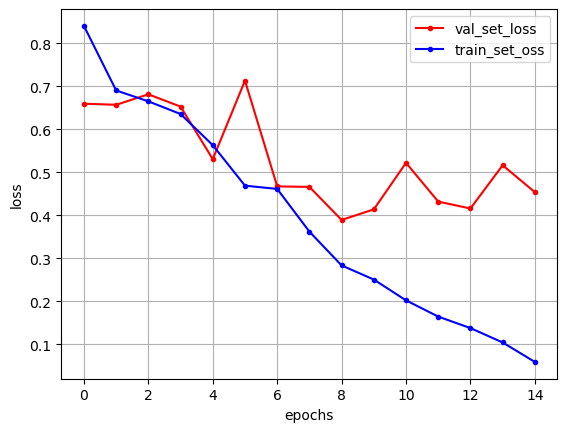

In [23]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()